In [19]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


타이타닉
- 캐글에서 머신러닝 학습용 제공하는 데이터 


1) 데이터 전처리
- 널처리
- 불필요한 속성 제거
- 레이블인코딩 ( 간략하게 하기 위해 ) 

2) 모델 핛브 및 검증 / 예측 / 평가
- 결정트리 , 랜덤포레스트 , 로지스틱 회귀 학습ㅂ ㅣ교 
- k-fold 교차 검증 
- cross_val_socre() , GridSearchCV로 교차검증 및 튜닝 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df =pd.read_csv('/content/gdrive/MyDrive/code/titanic/train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


생존여부 Suervived 가 타겟값 !! 

* Passengerid: 탑승자 데이터 일련번호
* survived: 생존 여부, 0 = 사망, 1 = 생존
* Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
* sex: 탑승자 성별
* name: 탑승자 이름
* Age: 탑승자 나이
* sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
* parch: 같이 탑승한 부모님 또는 어린이 인원수
* ticket: 티켓 번호
* fare: 요금
* cabin: 선실 번호
* embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [21]:
print('\n ### train 데이터 정보 ###  \n')
print(titanic_df.info())
# null은 cabin 선실번호 , age 나이 , embarked 중간 선착장 존재 이거 처리 필요


 ### train 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


** NULL 컬럼들에 대한 처리 **

In [22]:
# 나이는 널있으면 평균값으로 넣어줌 fillna 결측값을 다른 값으로 변환 
# inplace=true -> 데이터 프레임 보호없이 바로 결측값 채워넣기 
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)

# 나머지는 그냥 N을 넣어주기 
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)

# 전체 칼러별 null이 나오는데 그걸 다 합친게 또 sum으로 
print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum().sum())

데이터 세트 Null 값 갯수  0


In [23]:
print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum())
# 여기에 sum 한 번 더 쓰면 전체 널값 갯수 합

데이터 세트 Null 값 갯수  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [24]:
# 문자열 값들의 갯수들 ! 
print(' Sex 값 분포 :\n',titanic_df['Sex'].value_counts())

# cabin은 널값이 굉장히 많은 687개 다른 선실도 굉장히 많음 ...
# 방에 대한 부분이 과연 필요한가..? 앞에 등급만 알기 위해 앞에 알파벳하나만 가져가기 
print('\n Cabin 값 분포 :\n',titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n',titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
B96 B98          4
G6               4
C23 C25 C27      4
E101             3
              ... 
D45              1
B3               1
B78              1
C32              1
A10              1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [25]:
# 앞에 문자열 하나만 가져오려면 str이 필요함 !
# 잘 알아두기!!  
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]

# 선실이 알파벳으로 정리됨 이걸 다시 분포도를 value_count로 보면 깔끔하게 정리됨을 확인 
print(titanic_df['Cabin'].head(3))
titanic_df['Cabin'].value_counts()

0    N
1    C
2    N
Name: Cabin, dtype: object


N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [26]:
# 성별별로 사망자와 생송자가 되어 있는지 확인 
# 성별로 그룹바이하고 생존에 대해 그룹바이 및 생존자 수에 대한 카운트하기 

titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

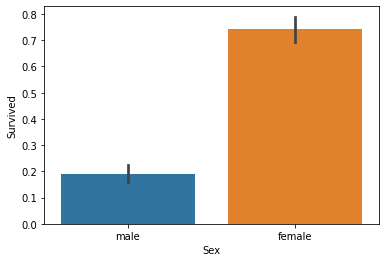

In [27]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)
# seabon은 데이터에 데이터프레임이 들어간다 
# 데이터프레임 넣어주면 알아서 컬럼 찾아준다 
# 저 데이터는 기본 데이터 프레임 아까 불러온 타이타닉 데이터셋 
# 작업 거친거라곤 널값 제거 및 피쳐값들 정리 

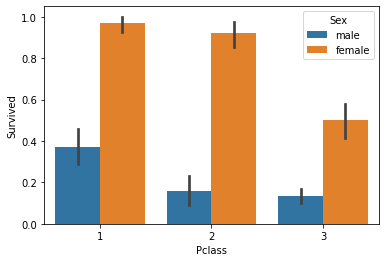

In [28]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)
# hue : hue에 해당하는 칼럼을 같이 비교해준다 
# x은 등급 y축은 생존인데 이 비교를 hue 에 해당하는 남녀로 비교해줌
# 보면 1등급이 좀더 살아남으셨고 그 와중 여자가 제일 많이 살아남음 레이디 퍼스트

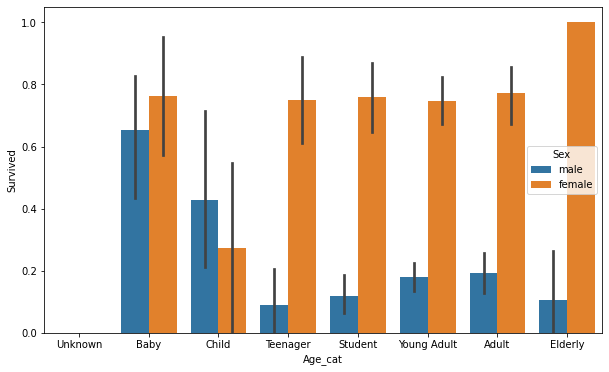

In [29]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용.
# 나이를 좀 그룹핑하기 위해서 사용  
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))

# 그래프가 1에 가까울 수록 생존 0에 가까울 수록 사망자.... 
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
# 다 구한다음 만든 칼럼 삭제 
titanic_df.drop('Age_cat', axis=1, inplace=True)

In [30]:
# 레이블 인코딩 
# fit -> transform 변환하기 
# 성별, 방, 중간선착장이 문자열이 아닌 숫자로 바뀜 
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [38]:
from sklearn.preprocessing import LabelEncoder
# 전처리용 함수로 만들어서 재사용 및 간편하게 쓰기 

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df


# 머신러닝 알고리즘에 불필요한 속성 제거
# 식별자 및 이름 , 티켓은 지금 상황에서 무쓸모라서 버리기 
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위의 3개 함수 묶는 함수 transform_feature 
# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df


In [39]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df =pd.read_csv('/content/gdrive/MyDrive/code/titanic/train.csv')

# 타겟값 y 
y_titanic_df = titanic_df['Survived']

#feature 값 x 
X_titanic_df= titanic_df.drop('Survived',axis=1)

# 타겟값 빠진 feature 값들을 위의 함수들로 전처리 하기 
X_titanic_df = transform_features(X_titanic_df)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=11)

# 1) feature 값들 ( 전처리 완료 )
# 2) target 값들 (목표로 하는 결과값)
# 이를 4개의 값들에 반환한다 

In [41]:
# 알고리즘 3개로 확인하기! 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 3개의 알고리즘으로 각각 학습 후 정확도를 평가함 

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))


DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [35]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    # 학습과 검증용 셋들이 합쳐서 5개 생기고 이를 5번 반복 
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
# 결정트리만 교차검증완료 
exec_kfold(dt_clf , folds=5) 


교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [36]:
from sklearn.model_selection import cross_val_score

# 5번의 교차검증을 수행한 정확도 값 반환 
scores = cross_val_score(dt_clf, X_titanic_df , y_titanic_df , cv=5)
for iter_count,accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


In [37]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

# 측정할 알고리즘 . 파라미터들 . 측정할 정확도 , 횟수 5
grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))


GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


1. 데이터 전처리 
- 데이터 클린징 
- 결손값 NULL, NAN처리
- 데이터 인코딩 ( 레이블 , 원-핫 인코딩 ) 
- 데이터 스케일링 
- 이상치 제거
- FEATURE 선택 및 추출 가공 

2. 데이터 세트 분리 
- 학습 데이터와 테스트 데이터 분리 

3. 모델 학습 및 검증 평가
- 알고리즘 학습 

4. 예측 수행 
- 테스트 데이터로 예측 수행 

5. 평가
- 예측 평가 


## 교차검증 
## cross_val_score()
## GridSearchCV